导入pandas包用于处理数据<br>
导入seborn和pyplot包用于画图<br>
tensorflow包提供placeholder占位符

In [33]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

这里定义为人口和利润

In [34]:
df = pd.read_csv('ex1data1.txt', names=['population','profit'])

In [35]:
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  97 non-null     float64
 1   profit      97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


lmplot绘制出散点图

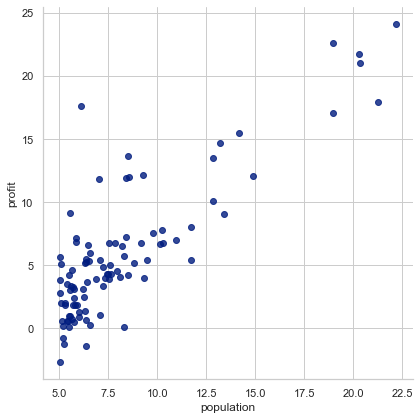

In [37]:
sns.lmplot(x='population', y='profit',data=df, height=6, fit_reg=False)
plt.show()

get_X函数
创建ones（dataframe类型）m行1列的1元素，并将ones这一列与传入的df合并，传出
类似 1,a
    1,b
    1,c
<br>
get_Y函数获取最后一列数据[a,b,c]

normalize_feature函数将传入的df全部按列归一化方便后续梯度下降

In [81]:
def get_X(df):#读取特征
    ones = pd.DataFrame({'ones':np.ones(len(df))})#ones是和pf等高的1元素
    data = pd.concat([ones,df], axis=1)#拼接ones和pd为data
    return data.iloc[:,:-1].values
def get_Y(df):#读取标签
    return np.array(df.iloc[:, -1])#获取df最后一列

def normalize_feature(df):#特征缩放，与平均数的差值/方差
    return df.apply(lambda column:(column - column.mean()) / column.std())

linear_regression函数进行梯度下降<br>


In [53]:
def linear_regression(X_data,y_data, alpha,epoch,optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    #放数据的graph
    X = tf.placeholder(tf.float32, shape = X_data.shape)
    y = tf.placeholder(tf.float32, shape = y_data.shape)
    
    with tf.varialbe_scope('liner-regression'):
        W = tf.get_variable("weights",
                           shape=(X_data.shape[1],1),#2行1列
                           initializer=tf.constant_initializer()) #n*1
        y_pred = tf.matmul(X, W) #m*n的矩阵乘 n*1 ->m*1矩阵
        # (m*1)T*(m*1) = 1*1
        #transpose_a/b说明矩阵a/b的转置
        #loss就是梯度下降中的代价函数J(θ)
        loss = 1/ (2 * len(X_data)) *tf.matmul((y_pred -y), (y_pred - y), transpose_a=True) 
    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)
    
    #run session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess_data = []
        for i in range(epoch):
            _, loss_val,W_val = sess.run([opt_operation, loss, W], feed_dict = {X:X_data, y:y_data})
            loss_data.append(loss_val[0,0]) #损失函数都是1*1矩阵
            
            if len(loss_data)>1 and np.abs(loss_data[-1] - loss_data[-2])<10 ** -9:
                print('Converged at epoch {}'.format(i))
                break
                
    #清除 graph
    tf.reset_default_gragh()
    return {'loss':loss_data, 'parameters': W_val}

In [52]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])

data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [47]:
X = get_X(data)
print(X.shape,type(X))

y = get_Y(data)
print(y.shape, type(y))

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [83]:
theta = np.zeros(X.shape[1])#X有两列，shape[0]表行数，shpae[1]=2是两列


lr_cost函数传入θ，样本里的x和y（需要拟合的值）<br>
定义m为样本数<br>
线性拟合函数最初始参数为θ0=0，θ1=0，h(x) = θ0+θ1x <br>
用x计算出的值h(x)-y(x)为差值，函数中的inner即为差值数组<br>
因为损失函数为差值平方的和/2m<br>
直接对差值矩阵inner乘其转置矩阵得差值平方的和

In [107]:
def lr_cost(theta, X, y):
#     X:R(m*n) ,m样本数，n 特征数
#     y：R(m)
#     theta:R(n) ,线性回归参数
    m = X.shape[0] #m样本数
    inner = X @ theta - y #R(m*1) ,X @ theta 等价于X.dot(theta)也即是矩阵乘法
    
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    
    return cost

In [97]:
lr_cost(theta, X, y)#返回损失函数的值

32.072733877455676

批量梯度下降函数（每一次梯度下降的过程中，都用到了所有样本，也就是所有的x，y）<br>
此处还没看懂！

In [109]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta - y) 
    
    return inner / m
print(X.T @ (X @ theta - y) /97)

[ -5.83913505 -65.32884975]


拟合线性回归，返回最后的两个参数θ0和θ1<br>
_theta拷贝原来的theta<br>
在epoch范围内循环执行梯度下降，并将损失函数添加到cost_data数组中<br>

In [59]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#     拟合线性回归，返回参数和代价
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy() #备份的theta
    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))
    return _theta, cost_data

In [61]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [62]:
final_theta

array([-2.28286727,  1.03099898])

In [63]:
cost_data

[32.072733877455676,
 6.737190464870011,
 5.931593568604956,
 5.901154707081388,
 5.895228586444221,
 5.890094943117332,
 5.885004158443646,
 5.8799324804914175,
 5.874879094762575,
 5.869843911806386,
 5.864826865312929,
 5.859827889932181,
 5.85484692057229,
 5.849883892376587,
 5.844938740722034,
 5.840011401218361,
 5.8351018097072265,
 5.830209902261388,
 5.825335615183862,
 5.820478885007098,
 5.815639648492155,
 5.810817842627869,
 5.806013404630045,
 5.80122627194063,
 5.796456382226899,
 5.791703673380653,
 5.7869680835173956,
 5.782249550975539,
 5.777548014315596,
 5.772863412319382,
 5.768195683989214,
 5.76354476854712,
 5.758910605434049,
 5.754293134309077,
 5.749692295048629,
 5.745108027745684,
 5.740540272709012,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333529,
 5.71347718436475,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.695757917651815,
 5.691367918863752,
 5.686993732597982,
 5.682635301898707,


In [64]:
lr_cost(final_theta, X, y)

4.713809531116866

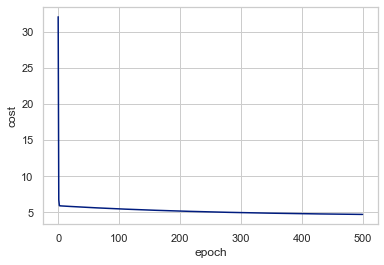

In [76]:
c = {'epoch':list(range(epoch+1)),'cost':cost_data}
cost_df = pd.DataFrame(c)
ax = sns.lineplot(x='epoch',y='cost',data = cost_df)
plt.show()

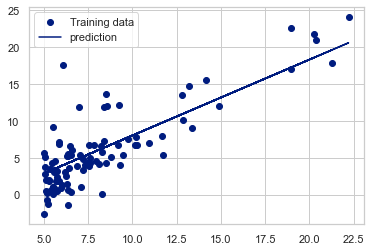

In [72]:
b = final_theta[0] #intercept,Y轴上的截距
m = final_theta[1] # slope ，斜率
print('fx = ')
plt.scatter(data.population,data.profit, label="Training data")
plt.plot(data.population, data.population*m + b,label="prediction")
plt.legend(loc=2)
plt.show()